## Import & Load

In [ ]:
!pip install scikeras

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.optimizers import SGD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/BitstampData.csv')

In [ ]:
dataset.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
2841372,1496188560,2190.49,2190.49,2181.37,2181.37,1.700166,3723.784755,2190.247337
2841373,1496188620,2190.50,2197.52,2186.17,2195.63,6.561029,14402.811961,2195.206304
2841374,1496188680,2195.62,2197.52,2191.52,2191.83,15.662847,34361.023647,2193.791712
2841375,1496188740,2195.82,2216.00,2195.82,2203.51,27.090309,59913.492565,2211.620837
2841376,1496188800,2201.70,2209.81,2196.98,2208.33,9.961835,21972.308955,2205.648801


## Data Prep

In [ ]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()
dataset=dataset.drop(columns=['Timestamp'])

In [ ]:
# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [ ]:
dataset.sample(5)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
2674788,1013.40,1013.40,1013.40,1013.40,0.021000,21.281400,1013.400000,1013.763,1011.670000,1.0
1942113,228.38,228.38,228.37,228.37,3.671553,838.508187,228.379678,228.298,227.922167,1.0
1920725,227.71,227.73,226.50,226.50,276.374359,62713.924046,226.916579,227.820,228.172833,0.0
2200910,412.76,413.25,412.35,413.23,8.000000,3303.700710,412.962589,412.024,413.688000,0.0
1458792,368.37,368.59,368.11,368.11,7.367643,2713.569295,368.308992,368.349,363.170667,1.0


## Feature Engineering

In [ ]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)

#calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA

In [ ]:
dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)

In [ ]:
dataset.sample(5)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
561673,17.87,17.87,17.87,17.87,1.000000,17.870000,17.870000,17.870,18.106333,0.0,...,45.560524,NaN,NaN,0.000000,0.000000,10.000000,10.000000,17.870,17.896000,18.23380
1711820,255.30,255.30,255.30,255.30,0.140510,35.872203,255.300000,255.444,254.163500,1.0,...,52.844255,52.702703,59.581456,83.644860,83.489097,91.566265,91.485944,255.444,254.603667,253.73790
2153344,376.20,376.20,376.06,376.06,9.417301,3541.508873,376.064103,376.130,376.283167,0.0,...,49.978129,50.000000,83.333333,46.987952,58.232932,22.674419,28.100775,376.130,376.197333,376.58605
1973898,243.00,243.00,243.00,243.00,19.597529,4762.199445,243.000000,243.236,243.147667,1.0,...,51.404986,22.807018,70.760234,28.571429,55.822790,78.005865,86.021505,243.236,243.282000,241.83710
1233131,434.07,434.07,434.07,434.07,7.000000,3038.490000,434.070000,433.245,430.650667,1.0,...,51.292557,53.955136,47.422275,62.927757,57.667934,69.930609,65.664354,433.245,431.715667,429.82135


In [ ]:
dataset = dataset.fillna(0)

In [ ]:
dataset.sample(5)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1573876,317.84,317.99,317.84,317.99,6.330000,2012.670078,317.957358,317.273,317.268333,1.0,...,51.320738,100.000000,42.296919,100.000000,43.169399,90.639269,74.809741,317.273,317.170667,315.91380
622843,42.59,42.75,42.59,42.75,3.553362,151.417687,42.612514,42.632,42.657833,0.0,...,48.195229,100.000000,75.641026,100.000000,75.641026,30.769231,22.888540,42.632,42.664000,42.77620
1925732,228.82,228.82,228.79,228.79,54.030000,12361.524710,228.790019,229.173,229.383333,0.0,...,48.692942,0.000000,11.363636,0.000000,10.000000,0.000000,8.928571,229.173,229.319333,229.41230
1142483,622.58,623.00,622.50,622.50,27.310653,17013.191452,622.950735,622.522,621.862833,1.0,...,54.839707,49.484536,50.515464,19.458763,19.780928,73.164448,73.271790,622.522,623.595333,608.53060
2146564,371.34,371.80,371.34,371.76,5.478672,2036.852570,371.778537,371.784,371.927833,0.0,...,48.631861,88.043478,89.855072,78.640777,80.258900,26.557377,27.103825,371.784,371.769333,372.83255


In [ ]:
dataset.shape

(2841377, 29)

## Explore Data

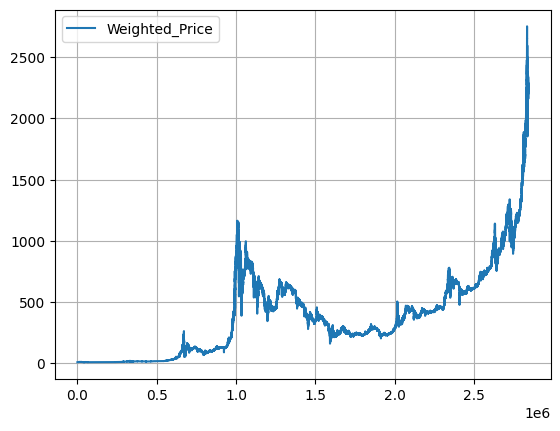

In [ ]:
dataset[['Weighted_Price']].plot(grid=True)
plt.show()

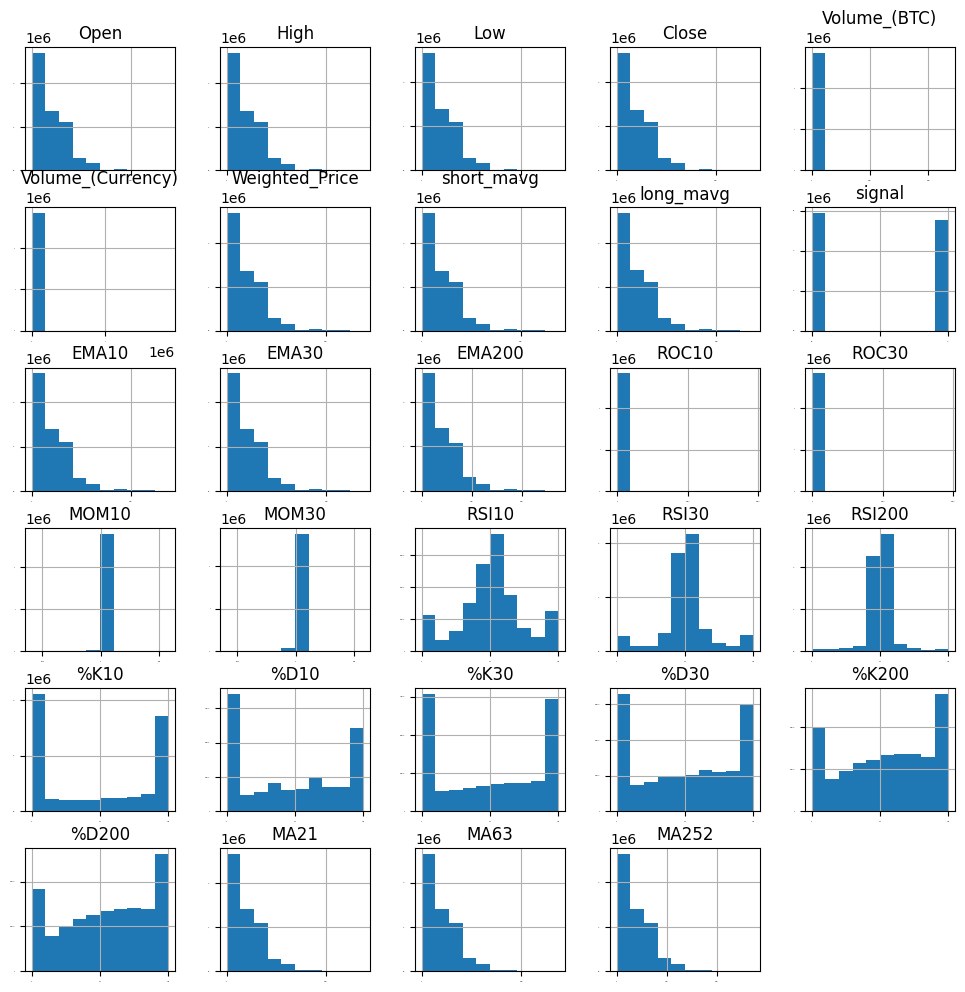

In [ ]:
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

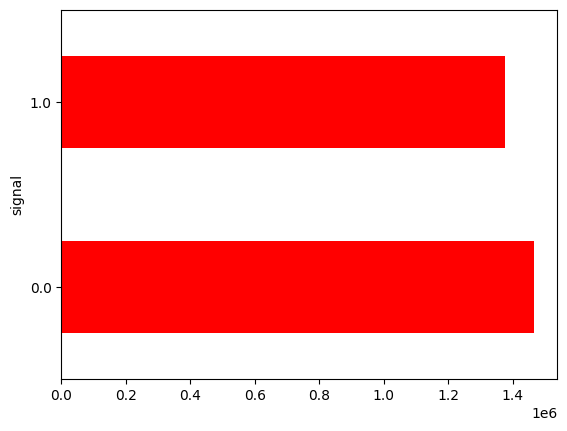

In [ ]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

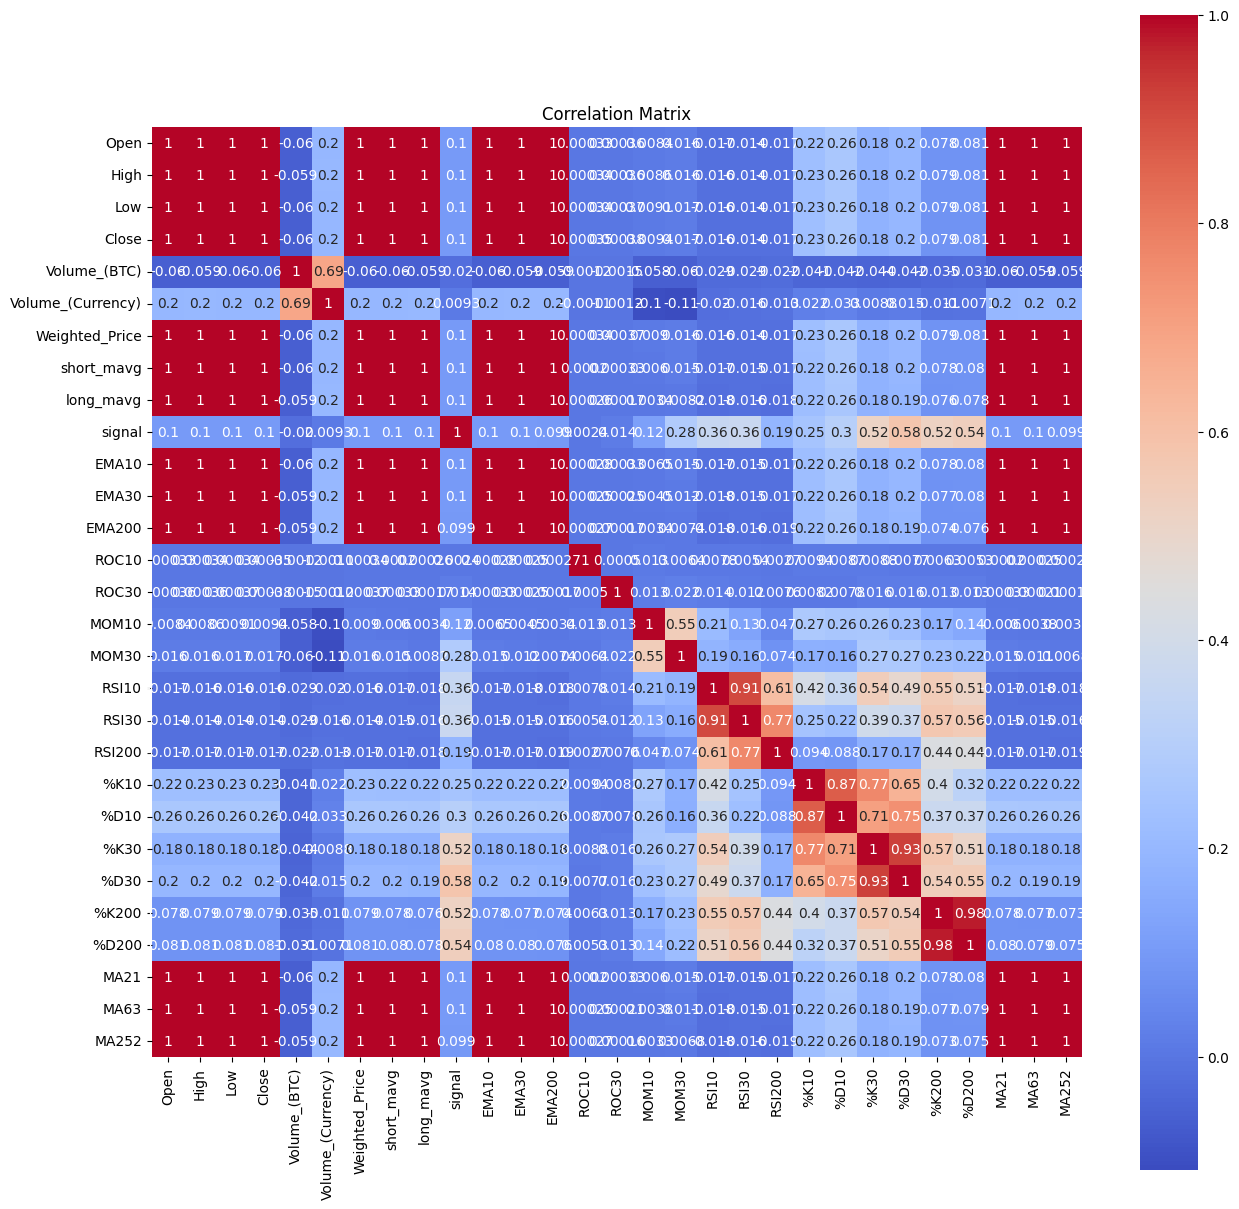

In [ ]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='coolwarm')

In [ ]:
dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)','short_mavg','long_mavg'], axis=1)

In [ ]:
dataset.sample(5)

,Close,Volume_(BTC),Weighted_Price,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1851566,288.66,0.563386,288.626917,0.0,288.266558,288.306919,287.930587,0.368567,-0.155650,1.13,...,49.546155,95.495495,70.220397,53.738318,39.875389,42.558140,39.108527,288.194,288.306000,288.27195
1798577,224.84,3.689430,224.809012,1.0,224.890182,224.882785,224.539782,-0.066670,-0.066670,-0.15,...,52.606668,59.459459,53.153153,59.459459,53.153153,87.288136,90.160471,224.897,224.937667,224.49110
197239,4.98,1.542017,4.980000,1.0,4.981578,4.980724,4.959635,0.000000,0.606061,0.00,...,67.707371,0.000000,0.000000,60.000000,60.000000,60.000000,60.000000,4.980,4.987000,4.95555
1871001,292.74,0.149000,292.740000,1.0,292.798282,292.768585,292.895130,-0.058038,0.078630,-0.17,...,49.943268,0.000000,0.000000,78.481013,78.481013,38.783270,38.783270,292.842,292.729333,292.91455
217316,5.07,18.317554,5.070000,0.0,5.070000,5.070000,5.071532,0.000000,0.000000,0.00,...,41.084911,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.070,5.070000,5.07000


## Model Train Testing

In [ ]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [ ]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

In [ ]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

#Neural Network
models.append(('NN', MLPClassifier()))

# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [ ]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.872775 (0.007326)
LDA: 0.888387 (0.002632)
KNN: 0.869387 (0.003411)
CART: 0.895613 (0.003502)
NB: 0.789612 (0.004958)
NN: 0.857550 (0.043162)
AB: 0.896200 (0.002715)
GBM: 0.908850 (0.002362)
RF: 0.929237 (0.002131)


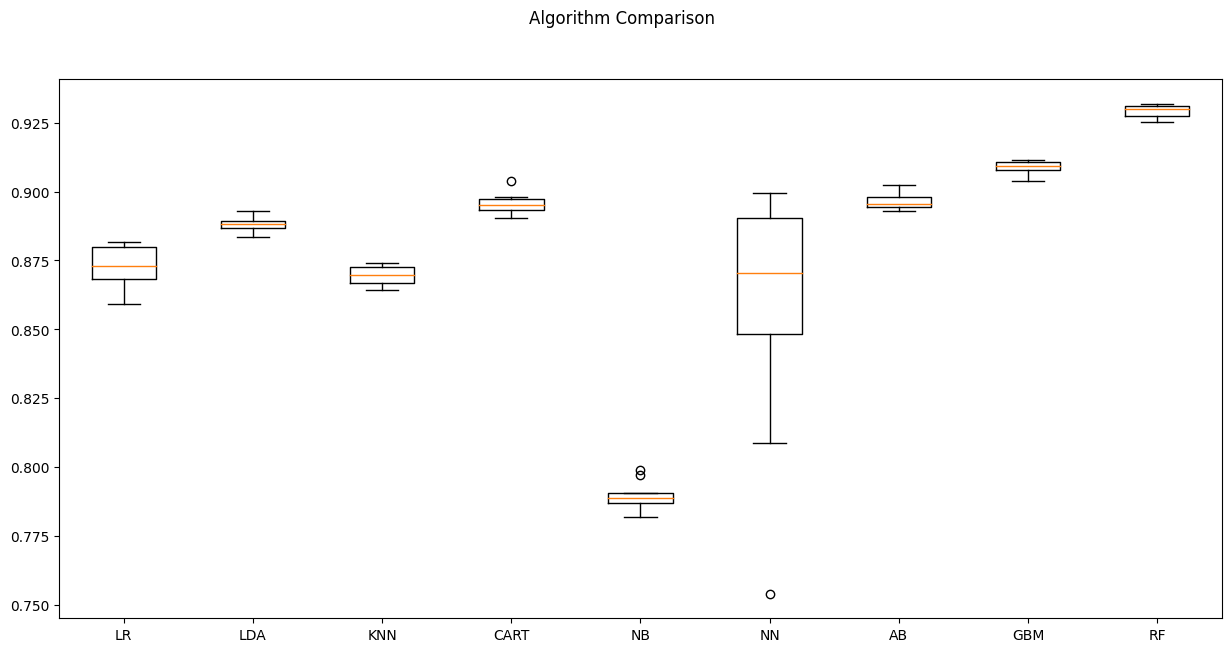

In [ ]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,7)
plt.show()

## Model Tuning

In [ ]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform.
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators.
    The maximum depth limits the number of nodes in the tree.
    Tune this parameter for best performance; the best value depends on the interaction of the input variables
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split.
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

'''
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.903763 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.868912 (0.003581) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.870325 (0.003357) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.901288 (0.002739) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.903763 (0.002484) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.867013 (0.004535) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#6 0.870275 (0.004951) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.901037 (0.002519) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#2 0.902000 (0.002909) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


## Model Performance

In [ ]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1)
#model = LogisticRegression()

model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [ ]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.90625
[[ 7888   968]
 [  907 10237]]
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89      8856
         1.0       0.91      0.92      0.92     11144

    accuracy                           0.91     20000
   macro avg       0.91      0.90      0.90     20000
weighted avg       0.91      0.91      0.91     20000



<Axes: xlabel='Predicted', ylabel='Actual'>

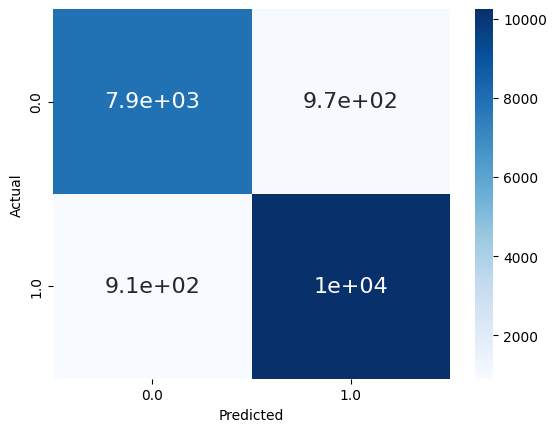

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

### Feature Importance

Text(0.5, 0, 'Variable Importance')

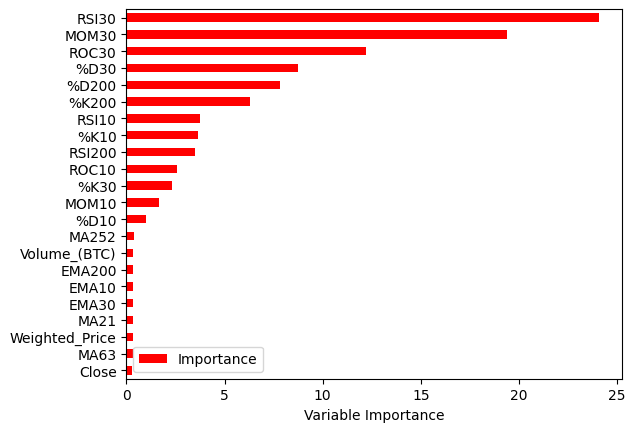

In [ ]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

## Backtesting

<Axes: >

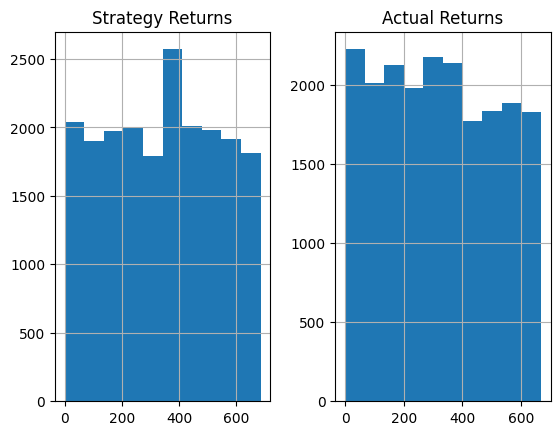

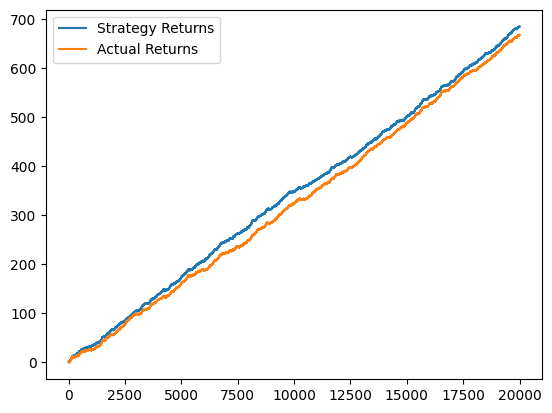

In [ ]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)

backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()

backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

# Consider Joining the Newsletter
Get updates on new videos, code, and discounts on future products / services

https://witty-motivator-1414.ck.page/acb393f729